In [1]:
"""
EATING DISORDERS MONTECATINI

Purpose: pp check for HDDMrl model.

(1) diag_cat (diagnostic category) 

- AN     anorexia, 
- BN     bulimia, 
- HC     university students not at risk according to the EAT-26,
- RI     university students at risk according to the EAT-26, recovered bulimics, recovered anorexics.

(2) stim (stimulus)

- food and neutral images,
- two neutral images.

Some participants have been removed so as to avoind problems with the Gelman-Rubin index.
All excluded participants belong to the HC group, apart from al_ro_1989_04_25_160_f, who is AN.
There are 296 participants.

I removed 6 participants from the RI group:

to_be_deleted = [
"lu_mu_1997_03_18_059_f",
"de_sc_1992_07_02_116_f",
"fr_ro_1982_08_15_048_f",
"el_li_1999_09_08_687_f",
"ma_pi_2001_05_11_566_f",
"sa_sa_2000_11_24_418_m"
]


Written by Corrado Caudek (2023-01-28)

"""


import datetime

now = datetime.datetime.now()
print("Current date and time : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-02-17 18:27:42


In [2]:
import hddm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc.progressbar as pbar
import pymc
import pathlib
import kabuki
from kabuki.utils import concat_models
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin
from patsy import dmatrix  # for generation of (regression) design matrices
import pickle
import numpy as np
from pandas import Series  # to manipulate data-frames generated by hddm
import pandas as pd
import arviz as az
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Data management
pd.options.display.max_colwidth = 100

# Plotting
%matplotlib inline

sns.set()  # for plot styling
plt.style.use('classic')

# HDDM
print("The hddm version is", hddm.__version__)

/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The hddm version is 0.9.7


In [3]:
# load accuracy-coded data ('response' column represents accuracy: 1=correct trial; 0=error trial) 
data = hddm.load_csv(
    "/Users/corrado/_repositories/eating_disorders_23/data/processed/prl/input_for_hddmrl/hddm_input_v3.csv"
)

to_be_deleted = [
    "lu_mu_1997_03_18_059_f",
    "de_sc_1992_07_02_116_f",
    "fr_ro_1982_08_15_048_f",
    "el_li_1999_09_08_687_f",
    "ma_pi_2001_05_11_566_f",
    "sa_sa_2000_11_24_418_m"
]

df = data.query("subj_code not in @to_be_deleted")
print("There are %d participants" % df["subj_idx"].nunique())

There are 296 participants


In [4]:
dicat_mapping = {
    "AN": "AN",
    "AN_R": "RI",
    "BN": "BN",
    "BN_R": "RI",
    "HC": "HC",
    "RI": "RI",
}
df = df.assign(diag_cat=df["diag_cat"].map(dicat_mapping))
df["diag_cat"].value_counts()

HC    62080
AN    11040
RI    10240
BN     3520
Name: diag_cat, dtype: int64

In [5]:
df["subj_idx"] = pd.factorize(df["subj_code"])[0] + 1
df["subj_idx"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [6]:
df.columns

Index(['subj_idx', 'response', 'stim', 'rt', 'trial', 'split_by', 'feedback',
       'diag_cat', 'subj_code', 'q_init'],
      dtype='object')

## Posterior predictive checks

An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approaximated posterior distribution for all of the estimated group and subject parameters (column).

Let us consider only the AN patients in the food condition.

In [7]:
# bn_df = df.loc[(df["diag_cat"] == "BN") & (df["stim"] == "food")]
bn_df = df.loc[(df["diag_cat"] == "BN")]
bn_df.shape


(3520, 10)

In [9]:
summary_stats = (
    bn_df.loc[:, ["subj_code", "stim", "rt"]]
    .groupby(["subj_code", "stim"])
    .aggregate(["count"])
)
# summary_stats.to_csv("fuck.csv")
summary_stats

rt
                               count
subj_code              stim         
al_ca_1996_03_27_621_f food      160
an_am_1996_05_12_176_f food      160
                       neutral   160
bi_an_2001_09_16_735_f food      160
                       neutral   160
ca_so_2001_01_09_118_f food      160
                       neutral   160
ch_be_1990_12_20_153_f food      160
                       neutral   160
ga_gi_2003_02_09_229_f food      160
                       neutral   160
gi_to_1996_02_02_043_f food      160
gr_de_2002_09_21_426_f food      160
                       neutral   160
ir_bo_1981_03_29_325_f food      160
                       neutral   160
lu_te_1990_10_28_496_f food      160
                       neutral   160
ma_ba_1995_05_25_321_f food      160
                       neutral   160
ra_al_2002_10_05_370_f food      160
                       neutral   160

Subjects that did not complete both food and neutral conditions must be removed.

In [10]:
to_be_removed = [
    "be_ma_1999_06_15_475_f",
    "gi_to_1996_02_02_043_f",
    "ch_br_1993_10_04_623_f",
    "ch_pi_2001_10_08_418_f",
    "cr_pa_1969_04_12_179_f",
    "ma_va_1998_07_04_538_f",
    "al_ca_1996_03_27_621_f"
]

bnx_df = bn_df.query("subj_code not in @to_be_removed")
print("There are %d participants" % bnx_df["subj_code"].nunique())

There are 10 participants


In [11]:
bnx_df["subj_idx"] = pd.factorize(bnx_df["subj_code"])[0] + 1
bnx_df["subj_idx"].unique()

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_23011/1335970088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bnx_df["subj_idx"] = pd.factorize(bnx_df["subj_code"])[0] + 1


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [12]:
bnx_df.head()

,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
960,1,0,food,1.294,1,0,1,BN,ch_be_1990_12_20_153_f,0.5
961,1,1,neutral,0.980,1,1,0,BN,ch_be_1990_12_20_153_f,0.5
962,1,0,food,0.633,2,0,0,BN,ch_be_1990_12_20_153_f,0.5
963,1,0,neutral,1.512,2,1,0,BN,ch_be_1990_12_20_153_f,0.5
964,1,0,food,1.898,3,0,0,BN,ch_be_1990_12_20_153_f,0.5


In [91]:
m = hddm.HDDMrl(
    bnx_df,
    # bias=True,
    depends_on={
        "a": ["stim"],
        "v": ["stim"],
        "t": ["stim"],
        "alpha": ["stim"],
        "pos_alpha": ["stim"],
    },
    dual=True,  # separate learning rates for pos/neg feedbacks
    p_outlier=0.05,
    informative=True,  # informative priors on ddm params
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [103]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        data=bnx_df,
        depends_on={
            "a": ["stim"],
            "v": ["stim"],
            "t": ["stim"],
            "alpha": ["stim"],
            "pos_alpha": ["stim"],
        },
        dual=True,  # separate learning rates for pos/neg feedbacks
        p_outlier=0.05,
        informative=True,
    )
    m.sample(500, burn=200, dbname="traces.db", db="pickle")
    models.append(m)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 501 of 500 complete in 37.5 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 500 of 500 complete in 38.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 500 of 500 complete in 35.5 sec

In [104]:
m = kabuki.utils.concat_models(models)

In [105]:
m.print_stats()

                                mean       std       2.5q       25q       50q       75q      97.5q    mc err
a(food)                     1.444729  0.088102   1.273797  1.383365  1.448879  1.506225   1.607278  0.002936
a(neutral)                  1.260146  0.099742   1.062558   1.19567   1.25749  1.314945   1.471997   0.00403
a_std                       0.303316  0.061191   0.208741  0.259427  0.294445  0.341611   0.440515  0.002939
a_subj(food).1              1.689846   0.07371    1.54923  1.642247  1.682718  1.735796   1.845301  0.003931
a_subj(food).2              1.470002  0.062426   1.350281  1.427898  1.465048  1.509568   1.597231  0.002778
a_subj(food).3              1.565523  0.059773   1.460145    1.5209  1.563953  1.606549   1.682933  0.002637
a_subj(food).4              1.300184  0.056001   1.202176  1.260507   1.29615  1.332531   1.420128   0.00279
a_subj(food).5              1.550677  0.074516    1.41353  1.497147  1.548907  1.601385   1.701022  0.003988
a_subj(food).6     

In [106]:
traces = m.get_traces()
traces.head()

,a(food),a(neutral),a_std,a_subj(food).1,a_subj(food).2,a_subj(food).3,a_subj(food).4,a_subj(food).5,a_subj(food).6,a_subj(food).7,...,pos_alpha_subj(neutral).1,pos_alpha_subj(neutral).2,pos_alpha_subj(neutral).3,pos_alpha_subj(neutral).4,pos_alpha_subj(neutral).5,pos_alpha_subj(neutral).6,pos_alpha_subj(neutral).7,pos_alpha_subj(neutral).8,pos_alpha_subj(neutral).9,pos_alpha_subj(neutral).10
0,1.412620,1.119896,0.303420,1.695260,1.444521,1.565500,1.313424,1.542819,1.446084,1.135571,...,-1.106211,6.128289,2.323339,1.180842,1.147294,0.954693,1.302262,2.499421,-3.445316,-1.857597
1,1.347046,1.358043,0.278509,1.664690,1.411099,1.509906,1.229615,1.475455,1.425787,1.127323,...,-0.845184,4.842107,3.221306,4.574614,2.350996,-0.358961,1.319765,1.048748,-3.102244,-1.516802
2,1.498959,1.238959,0.273241,1.731017,1.418344,1.522637,1.231834,1.622366,1.515832,1.150180,...,-1.290262,3.723844,4.095227,5.308884,2.442247,1.875966,1.269324,12.147401,-3.177974,-1.539178
3,1.487779,1.213451,0.358883,1.767959,1.423460,1.582026,1.392110,1.562284,1.501022,1.148797,...,-1.502206,3.546759,4.691548,7.809805,6.068440,8.029349,-0.339923,13.049537,-3.591210,0.030007
4,1.464852,1.278238,0.336705,1.669262,1.476773,1.474321,1.267535,1.486852,1.416893,1.182187,...,-1.731682,7.306441,2.324474,3.090502,3.400046,3.166269,-0.148413,5.997151,-2.519497,-1.813953


In [113]:
data = bnx_df

In [114]:
from tqdm import tqdm  # progress tracker

# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
data["samp"] = 0
# load traces
traces = m.get_traces()
# decide how many times to repeat simulation process. repeating this multiple times is generally recommended,
# as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 11)):
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0] - 1)
    # loop through all subjects in observed data
    for s in data.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 0)].trial.unique()
        )
        size1 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 1)].trial.unique()
        )
        # set parameter values for simulation
        a_n = traces.loc[sample, "a_subj(neutral)." + str(s)]
        t_n = traces.loc[sample, "t_subj(neutral)." + str(s)]
        scaler_n = traces.loc[sample, "v_subj(neutral)." + str(s)]
        alphaInv_n = traces.loc[sample, "alpha_subj(neutral)." + str(s)]
        alpha_n = np.exp(alphaInv_n) / (1 + np.exp(alphaInv_n))
        posAlphaInv_n = traces.loc[sample, "pos_alpha_subj(neutral)." + str(s)]
        pos_alpha_n = np.exp(posAlphaInv_n) / (1 + np.exp(posAlphaInv_n))
        
        a_f = traces.loc[sample, "a_subj(food)." + str(s)]
        t_f = traces.loc[sample, "t_subj(food)." + str(s)]
        scaler_f = traces.loc[sample, "v_subj(food)." + str(s)]
        alphaInv_f = traces.loc[sample, "alpha_subj(food)." + str(s)]
        alpha_f = np.exp(alphaInv_f) / (1 + np.exp(alphaInv_f))
        posAlphaInv_f = traces.loc[sample, "pos_alpha_subj(food)." + str(s)]
        pos_alpha_f = np.exp(posAlphaInv_f) / (1 + np.exp(posAlphaInv_f))
        
        # simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(
            a=a_n,
            t=t_n,
            scaler=scaler_n,
            alpha=alpha_n,
            pos_alpha=pos_alpha_n,
            size=size0,
            p_upper=0.7,
            p_lower=0.3,
            split_by=0,
        )
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a_f,
            t=t_f,
            scaler=scaler_f,
            alpha=alpha_f,
            pos_alpha=pos_alpha_f,
            size=size1,
            p_upper=0.7,
            p_lower=0.3,
            split_by=1,
        )
        # append the conditions
        sim_data0 = sim_data0.append([sim_data1], ignore_index=True)
        # assign subj_idx
        sim_data0["subj_idx"] = s
        # identify that these are simulated data
        sim_data0["type"] = "simulated"
        # identify the simulated data
        sim_data0["samp"] = i
        # append data from each subject
        sim_data = sim_data.append(sim_data0, ignore_index=True)
# combine observed and simulated data
ppc_data = data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "samp"]
].copy()
ppc_data["type"] = "observed"
ppc_sdata = sim_data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "type", "samp"]
].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv("ppc_data_tutorial.csv")

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_97241/633228653.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["samp"] = 0
100%|██████████| 10/10 [02:25<00:00, 14.52s/it]


In [124]:
plot_ppc_data = ppc_data[(ppc_data.trial > 60) & (ppc_data.trial < 81)].copy()

In [125]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_data["bin_trial"] = pd.cut(
    plot_ppc_data.trial, 11, labels=np.linspace(0, 10, 11)
).astype("int64")
# calculate means for each sample
sums = (
    plot_ppc_data.groupby(["bin_trial", "split_by", "samp", "type"])
    .mean()
    .reset_index()
)
# calculate the overall mean response across samples
ppc_sim = sums.groupby(["bin_trial", "split_by", "type"]).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_sim["upper_hpd"] = 0
ppc_sim["lower_hpd"] = 0
for i in range(0, ppc_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(
        sums.response[
            (sums["bin_trial"] == ppc_sim.bin_trial[i])
            & (sums["split_by"] == ppc_sim.split_by[i])
            & (sums["type"] == ppc_sim.type[i])
        ],
        alpha=0.1,
    )
    ppc_sim.loc[i, "upper_hpd"] = hdi[1]
    ppc_sim.loc[i, "lower_hpd"] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_sim["up_err"] = ppc_sim["upper_hpd"] - ppc_sim["response"]
ppc_sim["low_err"] = ppc_sim["response"] - ppc_sim["lower_hpd"]
ppc_sim["model"] = "RLDDM_single_learning"
ppc_sim.to_csv("ppc_choicedata_tutorial.csv")

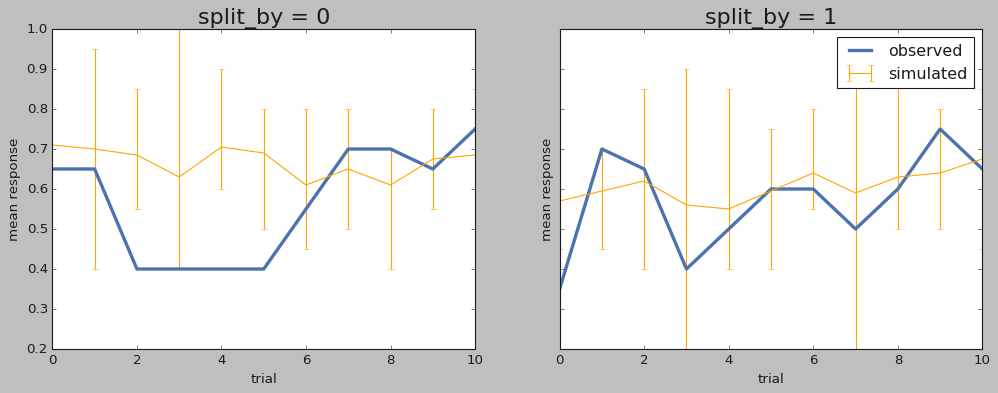

In [126]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=2, sharex=True, sharey=True)
for i in range(0, 2):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == "simulated")]
    ax.errorbar(
        d.bin_trial,
        d.response,
        yerr=[d.low_err, d.up_err],
        label="simulated",
        color="orange",
    )
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == "observed")]
    ax.plot(d.bin_trial, d.response, linewidth=3, label="observed")
    ax.set_title("split_by = %i" % i, fontsize=20)
    ax.set_ylabel("mean response")
    ax.set_xlabel("trial")
plt.legend()
fig.savefig("PPCchoice.pdf")